# CH2. 예제로 배우는 파이토치

### 파이토치의 두 가지 특징

1. **Tensor**: Numpy와 비슷하지만, GPU상에서 연산이 가능한 Tensor

2. **자동미분**: 신경망 구성을 구성하고 학습하는 과정





## 1. Numpy
Numpy를 통해 아래와 같은 신경망을 구현해보자


![python image](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/600px-Colored_neural_network.svg.png)


In [7]:
import numpy as np
from sklearn.metrics import r2_score

#batch size, input, hidden, output
N, D_in, H, D_out = 64, 1000, 100, 10

# input & output 생성
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

print("x.shape = {} // y.shape = {}".format(x.shape, y.shape))
#print("y.head =",y[:5 , ])

x.shape = (64, 1000) // y.shape = (64, 10)


In [8]:
# weight initalization
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

print("w1.shape = {} // w2.shape = {}".format(w1.shape, w2.shape))

w1.shape = (1000, 100) // w2.shape = (100, 10)


In [9]:
learning_rate = 1e-6

for t in range(500):
    #layer 1
    h = x.dot(w1)  # (64*1000)`(1000*100) --> 64*100
    
    #layer 2
    h_relu = np.maximum(h,0)
    
    #layer 3
    y_pred = h_relu.dot(w2)
    
    
    
    
    #loss 계산
    loss = np.square(y_pred - y).sum() # LSM (least-square Method)
    if t % 100 == 99:
        print(t+1, loss)
    
    
    
    ## back-probagation
    grad_y_pred = 2.0*(y_pred - y)   #1 
    grad_w2 = h_relu.T.dot(grad_y_pred) #2 
    
    grad_h_relu = grad_y_pred.dot(w2.T) #3
    grad_h = grad_h_relu.copy()
    grad_h[h<0] = 0
    
    grad_w1 = x.T.dot(grad_h)
    
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    


100 498.7917591232306
200 4.956555596061325
300 0.08518527447919391
400 0.001646969238093513
500 3.282135482228881e-05


## 참고: back propagation
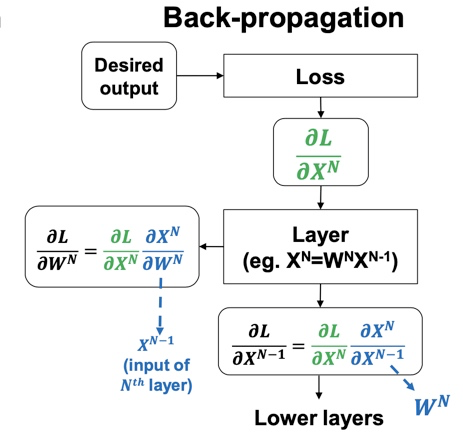

## 참고: 전체흐름

![python image](https://taewanmerepo.github.io/2017/12/whytranspose/010.jpg)

In [10]:
print("accuracy = ",r2_score(y_pred, y))

accuracy =  0.9999999470265932


## 2. Tensors

* Numpy와는 달리, Tensor는 GPU연산을 가능하게 함 --> 50배 이상의 속도향상

In [11]:
import torch

dtype = torch.float
#device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 무작위의 입력과 출력 데이터를 생성합니다.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# 무작위로 가중치를 초기화합니다.
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6

for t in range(500):
    # 순전파 단계: 예측값 y를 계산합니다.
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # 손실(loss)을 계산하고 출력합니다.
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # 손실에 따른 w1, w2의 변화도를 계산하고 역전파합니다.
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # 경사하강법(gradient descent)를 사용하여 가중치를 갱신합니다.
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

99 1039.2332763671875
199 10.371566772460938
299 0.16497258841991425
399 0.003740813583135605
499 0.000274020858341828


In [12]:
print("accuracy = ",r2_score(y_pred, y))

accuracy =  0.9999995633657047


## 3. Autograd
* 파이토치에서 제공하는 자동미분으로 신경망을 만들어보자

In [13]:
import torch
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

print("x.shape = ", x.shape)
print("y.shape = ", y.shape)
print("w1.shape = ", w1.shape)
print("w2.shape = ", w2.shape)

x.shape =  torch.Size([64, 1000])
y.shape =  torch.Size([64, 10])
w1.shape =  torch.Size([1000, 100])
w2.shape =  torch.Size([100, 10])


In [56]:
learning_rate = 1e-6
for t in range(500):
    # forwarding
    y_pred = x.mm(w1).clamp(min=0).mm(w2)    #mm은 행렬의 곱셈
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())
    
    # backwarding
    loss.backward()
    
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        w1.grad.zero_()
        w2.grad.zero_()
        

99 442.030517578125
199 3.0898475646972656
299 0.04491591826081276
399 0.0010282564908266068
499 9.954263077815995e-05


## 4. Autograd: 새로운 함수 정의

In [14]:
import torch



class MyReLU(torch.autograd.Function):
    """
    torch.autograd.Function을 상속받아 사용자 정의 autograd Function을 구현하고,
    Tensor 연산을 하는 순전파와 역전파 단계를 구현하겠습니다.
    """

    @staticmethod #데코레이터 부분으로, class를 외부에서도 사용가능하게 함
    def forward(ctx, input):
        """
        순전파 단계에서는 입력을 갖는 Tensor를 받아 출력을 갖는 Tensor를 반환합니다.
        ctx는 컨텍스트 객체(context object)로 역전파 연산을 위한 정보 저장에
        사용합니다. ctx.save_for_backward method를 사용하여 역전파 단계에서 사용할 어떠한
        객체도 저장(cache)해 둘 수 있습니다.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        역전파 단계에서는 출력에 대한 손실의 변화도를 갖는 Tensor를 받고, 입력에
        대한 손실의 변화도를 계산합니다.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input
    
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요.

# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# 가중치를 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # 사용자 정의 Function을 적용하기 위해 Function.apply 메소드를 사용합니다.
    # 여기에 'relu'라는 이름을 붙였습니다.
    relu = MyReLU.apply

    # 순전파 단계: Tensor 연산을 사용하여 예상되는 y 값을 계산합니다;
    # 사용자 정의 autograd 연산을 사용하여 ReLU를 계산합니다.
    y_pred = relu(x.mm(w1)).mm(w2)

    # 손실을 계산하고 출력합니다.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t+1, loss.item())

    # autograde를 사용하여 역전파 단계를 계산합니다.
    loss.backward()

    # 경사하강법(gradient descent)을 사용하여 가중치를 갱신합니다.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # 가중치 갱신 후에는 수동으로 변화도를 0으로 만듭니다.
        w1.grad.zero_()
        w2.grad.zero_()


100 309.832763671875
200 1.3837536573410034
300 0.011589820496737957
400 0.0003075986460316926
500 5.240651444182731e-05


## 5. nn패키지

In [15]:
# -*- coding: utf-8 -*-
import torch

# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# nn 패키지를 사용하여 모델을 순차적 계층(sequence of layers)으로 정의합니다.
# nn.Sequential은 다른 Module들을 포함하는 Module로, 그 Module들을 순차적으로
# 적용하여 출력을 생성합니다. 각각의 Linear Module은 선형 함수를 사용하여
# 입력으로부터 출력을 계산하고, 내부 Tensor에 가중치와 편향을 저장합니다.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# 또한 nn 패키지에는 널리 사용하는 손실 함수들에 대한 정의도 포함하고 있습니다;
# 여기에서는 평균 제곱 오차(MSE; Mean Squared Error)를 손실 함수로 사용하겠습니다.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):

    y_pred = model(x) #forward
    loss = loss_fn(y_pred, y) #loss    
    if t % 100 == 99:
        print(t, loss.item())
    model.zero_grad()
    loss.backward() #backward

    # 경사하강법(gradient descent)를 사용하여 가중치를 갱신합니다. 각 매개변수는
    # Tensor이므로 이전에 했던 것과 같이 변화도에 접근할 수 있습니다.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
            
    

99 2.033674716949463
199 0.02448652870953083
299 0.0006508223596028984
399 2.6567380700726062e-05
499 1.4120707874099026e-06


## 6. optim패키지

In [64]:
# -*- coding: utf-8 -*-
import torch

# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# nn 패키지를 사용하여 모델을 순차적 계층(sequence of layers)으로 정의합니다.
# nn.Sequential은 다른 Module들을 포함하는 Module로, 그 Module들을 순차적으로
# 적용하여 출력을 생성합니다. 각각의 Linear Module은 선형 함수를 사용하여
# 입력으로부터 출력을 계산하고, 내부 Tensor에 가중치와 편향을 저장합니다.

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

#학습률
learning_rate = 1e-4
#손실함수
loss_fn = torch.nn.MSELoss(reduction='sum')
#optimizer
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

for t in range(500):
    y_pred = model(x) #forward
    loss = loss_fn(y_pred, y) #loss
    if t % 100 == 99:
        print(t, loss.item())    
    optimizer.zero_grad() #grad zero
    loss.backward() #backward
    optimizer.step() #update
            
    

99 43.867225646972656
199 0.9217098355293274
299 0.011895142495632172
399 0.00011231042299186811
499 6.783675985388982e-07


## 7. 사용자 nn 패키지


In [16]:
import torch

class TwoLayerNet(torch.nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__() # 부모 클래스의 속성을 상속받겠다.
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H,D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min = 0)
        y_pred = self.linear2(h_relu)
        return y_pred

    
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)


#모델
model = TwoLayerNet(D_in, H, D_out)
#손실함수
criterion = torch.nn.MSELoss(reduction= 'sum')
#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4)

for t in range(500):
    y_pred = model(x) #forward
    loss = criterion(y_pred, y) #loss
    
    if t % 100 == 99:
        print(t+1, loss.item())
    optimizer.zero_grad()
    loss.backward() #backward
    optimizer.step() #update
    



100 2.0438852310180664
200 0.03144685924053192
300 0.0009326757281087339
400 3.6603392800316215e-05
500 1.664108935983677e-06


# 8. PyTorch: 제어 흐름(Control Flow) + 가중치 공유(Weight Sharing)


In [18]:
# -*- coding: utf-8 -*-
import random
import torch


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        생성자에서 순전파 단계에서 사용할 3개의 nn.Linear 인스턴스를 생성합니다.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        
        self.middle_linear = torch.nn.Linear(H, H)
        
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        모델의 순전파 단계에서, 무작위로 0, 1, 2 또는 3 중에 하나를 선택하고
        은닉층을 계산하기 위해 여러번 사용한 middle_linear Module을 재사용합니다.

        각 순전파 단계는 동적 연산 그래프를 구성하기 때문에, 모델의 순전파 단계를
        정의할 때 반복문이나 조건문과 같은 일반적인 Python 제어 흐름 연산자를 사용할
        수 있습니다.

        여기에서 연산 그래프를 정의할 때 동일 Module을 여러번 재사용하는 것이
        완벽히 안전하다는 것을 알 수 있습니다. 이것이 각 Module을 한 번씩만 사용할
        수 있었던 Lua Torch보다 크게 개선된 부분입니다.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
            
        y_pred = self.output_linear(h_relu)
        return y_pred


# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# 앞서 정의한 클래스를 생성(instantiating)하여 모델을 구성합니다.
model = DynamicNet(D_in, H, D_out)

# 손실함수와 Optimizer를 만듭니다. 이 이상한 모델을 순수한 확률적 경사 하강법
# (stochastic gradient decent)으로 학습하는 것은 어려우므로, 모멘텀(momentum)을
# 사용합니다.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(500):
    # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
    y_pred = model(x)

    # 손실을 계산하고 출력합니다.
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 변화도를 0으로 만들고, 역전파 단계를 수행하고, 가중치를 갱신합니다.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 0.005791769828647375
199 1.626948886723767e-07
299 7.130454213188919e-12
399 1.7906284094371117e-12
499 1.9676222456910253e-12


# 9. 직접 만들어 본 신경망

In [79]:
# 내가 해본거

import torch

#배치 사이즈 = 64, 원하는 모델은 hidden layer가 두 개일 때,
N, D_in, H1, H2, D_out = 64, 1000, 100, 50, 10

# 임의의 입력과 출력
x = torch.randn(N,D_in)
y = torch.randn(N,D_out)

# 내 모델
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1,H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2,D_out)
)

# 학습률 정의
lr = 1e-4

# loss와 optim 정의
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr )



# 학습
for t in range(500):
    
    y_pred = model(x) # forward
    loss = loss_fn(y_pred, y) #loss 계산
    
    if t % 100 == 99:  #출력
        print(t+1, loss.item())
    
    optimizer.zero_grad() #grad가 buffer를 사용하지 않고, 계속 누적되는 형태
    loss.backward() #back-propagation
    optimizer.step() #optim
    
#평가
print()

100 0.3403121829032898
200 0.04073870927095413
300 0.0024397787638008595
400 0.00014879260561428964
500 1.1253879165451508e-05



In [94]:
# nn.modul을 이용해 만들기.
import torch
import torch.nn as nn

#배치 사이즈 = 64, 원하는 모델은 hidden layer가 두 개일 때,
N, D_in, H1, H2, D_out = 64, 1000, 100, 50, 10

# 임의의 입력과 출력
x = torch.randn(N,D_in)
y = torch.randn(N,D_out)


class DNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H,H), #hidden1 --> hidden2
            nn.ReLU(),
            nn.Linear(H,H), #hideen2 --> hidden3
            nn.ReLU(),
            nn.Linear(H,D_out),
        )
        
    def forward(self,x):
        y_pred = self.layer(x)
        return y_pred

N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

#모델
model = DNN(D_in, H, D_out)

#학습률
learing_rate = 1e-4

#loss, optim
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for t in range(500):
    # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
    y_pred = model(x)

    # 손실을 계산하고 출력합니다.
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 변화도를 0으로 만들고, 역전파 단계를 수행하고, 가중치를 갱신합니다.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



99 0.4905935227870941
199 0.0128953130915761
299 8.44225287437439e-05
399 1.612039852716407e-07
499 5.451731774352986e-11


In [109]:
print(r2_score(y_pred.detach().numpy(), y.numpy()))

0.9999999999474619
